In [74]:
# Imports - you can add any other permitted libraries
import numpy as np
import pandas as pd

# You may add any other functions to make your code more modular. However,
# do not change the function signatures (name and arguments) of the given functions,
# as these functions will be called by the autograder.

def generate(N, theta, input_mean, input_sigma, noise_sigma):
    """
    Generate normally distributed input data and target values
    Note that we have 2 input features
    Parameters
    ----------
    N : int
        The number of samples to generate.
        
    theta : numpy array of shape (3,)
        The true parameters of the linear regression model.
        
    input_mean : numpy array of shape (2,)
        The mean of the input data.
        
    input_sigma : numpy array of shape (2,)
        The standard deviation of the input data.
        
    noise_sigma : float
        The standard deviation of the Gaussian noise.
        
    Returns
    -------
    X : numpy array of shape (N, 2)
        The input data.
        
    y : numpy array of shape (N,)
        The target values.
    """
    # Generate x1 and x2 independently
    X = np.random.normal(loc=input_mean, scale=input_sigma, size=(N, 2))
    
    # Add intercept term (x0 = 1)
    X_intercept = np.hstack((np.ones((N, 1)), X))  # Shape (N, 3)
    
    # Generate noise
    noise = np.random.normal(loc=0, scale=noise_sigma, size=N)
    
    # Compute target variable y
    y = X_intercept @ theta + noise  # Matrix multiplication
    
    return X, y

class StochasticLinearRegressor:
    def __init__(self):
        self.theta = None
        self.epochs = 10000
        self.epsilon = 1e-5
    
    def fit(self, X, y, learning_rate=0.01,batch_size=32):
        """
        Fit the linear regression model to the data using Gradient Descent.
        
        Parameters
        ----------
        X : numpy array of shape (n_samples, n_features)
            The input data.
            
        y : numpy array of shape (n_samples,)
            The target values.

        learning_rate : float
            The learning rate to use in the update rule.
            
        Returns
        -------
        List of Parameters: numpy array of shape (n_iter, n_features+1,)
            The list of parameters obtained after each iteration of Gradient Descent.
        """
        N, d = X.shape
        X_intercept = np.hstack((np.ones((N, 1)), X))
        self.theta = np.zeros(d + 1) 
        
        history = [] 
        prev_loss = float('inf')
        
        for epoch in range(self.epochs):
            indices = np.random.permutation(N) 
            X_shuffled = X_intercept[indices]
            y_shuffled = y[indices]
            
            loss_sum = 0
            for i in range(0, N, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                # Compute gradient
                gradient = np.matmul(X_batch.T, np.matmul(X_batch, self.theta) - y_batch) / X_batch.shape[0]
                
                # Update parameters
                self.theta -= learning_rate * gradient
                history.append(self.theta.copy())
                
                # Compute batch loss
                loss_sum += np.mean((y_batch - X_batch @ self.theta) ** 2)
            
            avg_loss = loss_sum / (N // batch_size)
            # history.append(self.theta.copy())
            
            # Check convergence criteria
            if abs(avg_loss - prev_loss) <= self.epsilon:
                print(f'Converged after {epoch} epochs')
                break
            prev_loss = avg_loss
        
        return np.array(history)
    
    def predict(self, X):
        """
        Predict the target values for the input data.
        
        Parameters
        ----------
        X : numpy array of shape (n_samples, n_features)
            The input data.
            
        Returns
        -------
        y_pred : numpy array of shape (n_samples,)
            The predicted target values.
        """
        N = X.shape[0]
        X_intercept = np.hstack((np.ones((N, 1)), X)) 
        return X_intercept @ self.theta


## 1


In [53]:
# Sample 1 million data points
theta = np.array([3, 1, 2])
input_mean = np.array([3, -1])
input_sigma = np.array([4, 4])
noise_sigma = np.sqrt(2)

X, Y = generate(1000000, theta, input_mean, input_sigma, noise_sigma)

# Split data into 80% training and 20% testing
train_size = int(0.8 * 1000000)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

In [36]:
pd.DataFrame(X_train).to_csv("generated_train_x.csv", index=False, header=False)
pd.DataFrame(Y_train).to_csv("generated_train_y.csv", index=False, header=False)
pd.DataFrame(X_test).to_csv("generated_test_x.csv", index=False, header=False)
pd.DataFrame(Y_test).to_csv("generated_test_y.csv", index=False, header=False)

## 2


In [75]:
# Train models with different batch sizes
batch_sizes = [1, 80, 8000, 800000]
learned_thetas = {}
histories = {}

In [56]:
import time

In [76]:
for batch_size in batch_sizes:
    model = StochasticLinearRegressor()
    start = time.time()
    history = model.fit(X_train, Y_train, learning_rate=0.001, batch_size=batch_size)
    end = time.time()
    elapsed_time = end - start
    learned_thetas[batch_size] = history[-1]  # Store final learned theta
    histories[batch_size] = history
    print(f"Learned θ for batch size {batch_size}: {history[-1]}")
    print(f"Time taken for batch size {batch_size}: {elapsed_time:.4f} seconds")

Converged after 28 epochs
Learned θ for batch size 1: [2.96925651 1.01119143 2.05958038]
Time taken for batch size 1: 179.5020 seconds
Converged after 7 epochs
Learned θ for batch size 80: [2.99848874 0.99830698 1.99831796]
Time taken for batch size 80: 0.8997 seconds
Converged after 91 epochs
Learned θ for batch size 8000: [2.98868344 1.00148966 1.99979509]
Time taken for batch size 8000: 5.7025 seconds
Converged after 5321 epochs
Learned θ for batch size 800000: [2.88401131 1.01387318 1.99569734]
Time taken for batch size 800000: 385.6835 seconds


## 3b

In [63]:
# Compute Closed Form Solution
def closed_form_solution(X, y):
    X_intercept = np.hstack((np.ones((X.shape[0], 1)), X))  # Add intercept term
    return np.linalg.inv(X_intercept.T @ X_intercept) @ X_intercept.T @ y

closed_form_theta = closed_form_solution(X_train, Y_train)
print(f"Closed-form solution for θ: {closed_form_theta}")

Closed-form solution for θ: [2.9996992  1.00019701 2.00022886]


## 4

In [64]:
# Compute Mean Squared Errors for all learned thetas
mse_results = {}

for batch_size, theta in learned_thetas.items():
    train_predictions = np.hstack((np.ones((X_train.shape[0], 1)), X_train)) @ theta
    test_predictions = np.hstack((np.ones((X_test.shape[0], 1)), X_test)) @ theta
    
    train_error = np.mean((Y_train - train_predictions) ** 2)
    test_error = np.mean((Y_test - test_predictions) ** 2)
    
    mse_results[batch_size] = (train_error, test_error)
    print(f"Batch Size {batch_size}: Training Error = {train_error}, Test Error = {test_error}")

# Compute Mean Squared Error for Closed-form Solution
train_predictions_closed = np.hstack((np.ones((X_train.shape[0], 1)), X_train)) @ closed_form_theta
test_predictions_closed = np.hstack((np.ones((X_test.shape[0], 1)), X_test)) @ closed_form_theta

train_error_closed = np.mean((Y_train - train_predictions_closed) ** 2)
test_error_closed = np.mean((Y_test - test_predictions_closed) ** 2)

print(f"Closed-form Solution: Training Error = {train_error_closed}, Test Error = {test_error_closed}")


Batch Size 1: Training Error = 2.0070291471352255, Test Error = 2.0046009122584327
Batch Size 80: Training Error = 1.9971027641545818, Test Error = 1.995286882941997
Batch Size 8000: Training Error = 1.9971002144337986, Test Error = 1.9953522095340692
Batch Size 800000: Training Error = 2.0052528907507554, Test Error = 2.0029240110837234
Closed-form Solution: Training Error = 1.9970153510682878, Test Error = 1.9953332652342235


In [65]:
import matplotlib.pyplot as plt

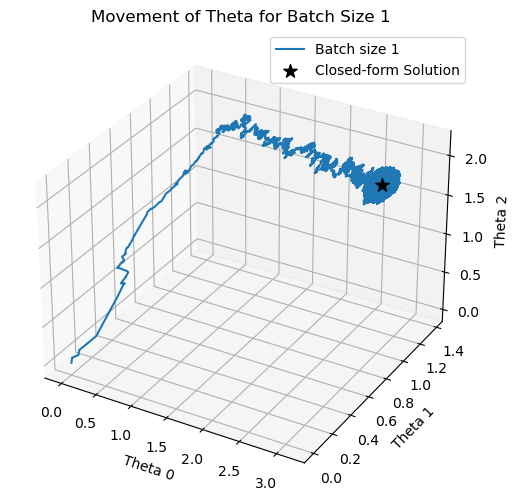

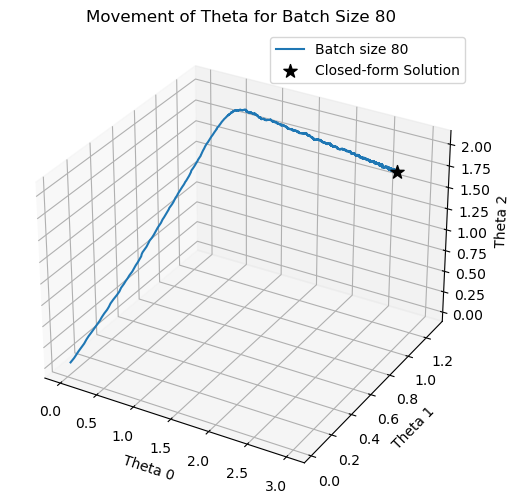

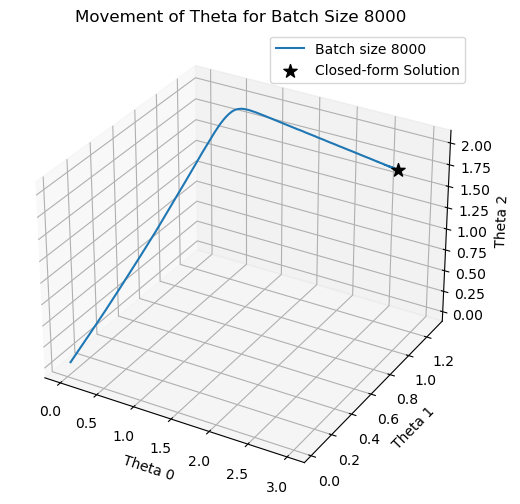

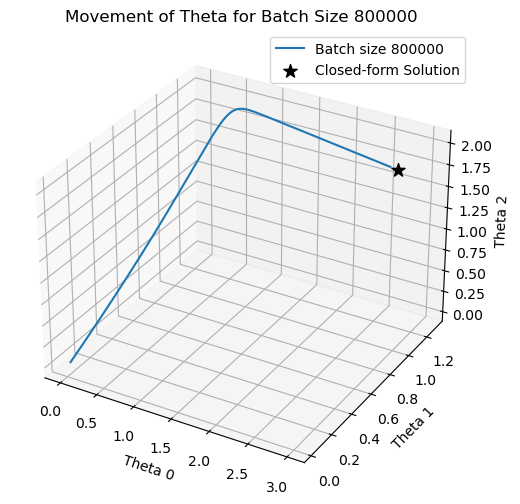

In [77]:
# Plot movement of θ for each batch size separately
for i, batch_size in enumerate(batch_sizes):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    history = np.array(histories[batch_size])
    ax.plot(history[:, 0], history[:, 1], history[:, 2], label=f"Batch size {batch_size}")
    ax.scatter(closed_form_theta[0], closed_form_theta[1], closed_form_theta[2], color='k', marker='*', s=100, label="Closed-form Solution")
    ax.set_xlabel("Theta 0")
    ax.set_ylabel("Theta 1")
    ax.set_zlabel("Theta 2")
    ax.set_title(f"Movement of Theta for Batch Size {batch_size}")
    ax.legend()
    plt.show()